In [1]:
import pycuda.autoinit
from pycuda.compiler import SourceModule
import pycuda.driver as drv
import numpy as np
import matplotlib.pyplot as plt

# Leer Kernel

In [2]:
# Lee el archivo kernel.cu
with open("../src/mono_sed.cu", "r") as f:
    kernel_code = f.read()
mod = SourceModule(kernel_code)    
# Accede a la función del kernel
compute_phi_new = mod.get_function("compute_phi_new")

# Configurar las condiciones iniciales del PVI y parámetros de la EDP

In [3]:
phi_ini = np.float64(0.175)             # Concentración inicial del fluido
phimin = np.float64(0.0)                # Concentración mínima del fluido
phimax = np.float64(0.519852941)        # Concentración máxima del fluido
v0 = np.float64(0.012)                  # Parámetro f_bk 
nrz = np.float64(1.9291211044205632)    # Parámetro f_bk 
T = np.float64(5)                       # Tiempo 
L = np.float64(0.303)                   # Largo del dominio [0,L]

# Configurar parámetros de método numérico

In [15]:
# Crear datos en el host 
n = np.int32((1<<15))

# Condición inicial
phi = np.zeros(2 * n, dtype=np.float64)
phi[:n] = phi_ini
phi[n:] = np.float64(0.0)

cfl = np.float64(0.8)
dx = np.float64(L / n)                   # Paso espacial (dominio de x de 0 a L)
dt = np.float64(cfl * dx / np.max(phi))  # Paso temporal inicial
dt_dx = np.float64(dt / dx)

# Configurar parámetros GPU

In [16]:
# Configuración de los bloques y los hilos
block_size = (1024, 1, 1)
grid_size = (int(np.ceil(2 * n / block_size[0])), 1, 1)

# Asignar memoria en el dispositivo (GPU)
phi_gpu = drv.mem_alloc(phi.nbytes)

# Copiar los datos del host al dispositivo
drv.memcpy_htod(phi_gpu, phi)

In [17]:
print("Parámetros EDP:")
print(f"  - phi_ini: {phi_ini} [kg/m^3]")
print(f"  - phi_min: {phimin} [kg/m^3]")
print(f"  - phi_max: {phimax} [kg/m^3]")
print(f"  - Tiempo de simulación: {T} [s]")
print(f"  - Largo del dominio: {L} [m]")
print("\nParámetros Método Numérico:")
print(f"  - CFL: {cfl}")
print(f"  - Mallado: {n} celdas")
print(f"  - dx: {dx} [s]")
print(f"  - dt: {dt} [m]")
print("\nParámetros GPU:")
print(f"  - Memoria: {phi.nbytes // (1024.0 ** 2)} MB")
print(f"  - Tamaño bloque: {block_size[0]} hilos")
print(f"  - Tamaño grilla: {grid_size[0]} bloques")

Parámetros EDP:
  - phi_ini: 0.175 [kg/m^3]
  - phi_min: 0.0 [kg/m^3]
  - phi_max: 0.519852941 [kg/m^3]
  - Tiempo de simulación: 5.0 [s]
  - Largo del dominio: 0.303 [m]

Parámetros Método Numérico:
  - CFL: 0.8
  - Mallado: 32768 celdas
  - dx: 9.246826171875e-06 [s]
  - dt: 4.227120535714286e-05 [m]

Parámetros GPU:
  - Memoria: 0.0 MB
  - Tamaño bloque: 1024 hilos
  - Tamaño grilla: 64 bloques


# Cálculo de la solución usando el Kernel de CUDA 

In [18]:
try:
    t=np.int32(0)
    T_actual = 0
    result = np.empty_like(phi)
    while T_actual <T:
        compute_phi_new(phi_gpu, dt_dx, phimin, phimax, v0,  nrz, n, t, block=block_size, grid=grid_size)
        pycuda.autoinit.context.synchronize()  # Sincronizar después de la primera fase

        # Paso temporal 
        T_actual = T_actual + dt
        t = np.int32(t+1)
    # Copiar los datos de vuelta al host 
    drv.memcpy_dtoh(result, phi_gpu)

finally:
    # Liberar la memoria
    phi_gpu.free()
    print("Memoria liberada")

Memoria liberada


# Plot Tiempo Final

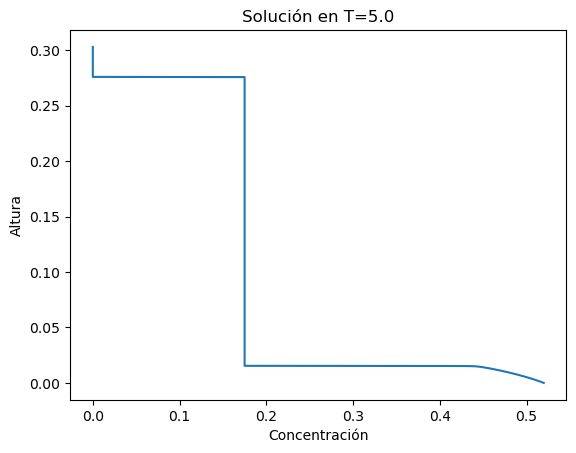

In [19]:
plt.plot(np.flip(result[:n]),np.linspace(0,L,n)[0:n],label='Solución')
plt.title(f"Solución en T={T}")
plt.xlabel("Concentración")
plt.ylabel("Altura")
plt.show()